In [2]:
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
import tensorflow as tf
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from dmba import plotDecisionTree

from sklearn.metrics import classification_report

In [3]:
import warnings

warnings.filterwarnings("ignore")

# **Carga de datos**
---

In [4]:
df = pd.read_csv('../drinking_water_potability.csv')
df.head(5)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,7.080795,204.890456,20791.31898,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.05786,6.635246,333.775777,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.54173,9.275884,333.775777,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.41744,8.059332,356.886136,363.266516,18.436525,100.341674,4.628771,0
4,9.092223,181.101509,17978.98634,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


Potability
0    1998
1    1278
Name: count, dtype: int64


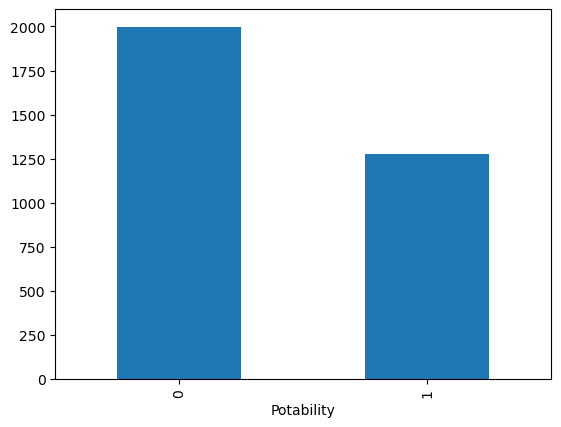

In [5]:
df['Potability'].value_counts().plot(kind='bar')
print(df['Potability'].value_counts())

# **Balanceo**
---

In [9]:
''' Imputación de datos mediante una  imputador iterativo usando sklearn:

    Se crea una instancia del imputador iterativo. Este imputador se 
    utilizará para estimar y completar los valores faltantes en los datos.

'''
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Inicializar el imputador iterativo
imputer = IterativeImputer()

# Entrenar el imputador en los datos con valores faltantes
imputed_data = imputer.fit_transform(df)

# Transformar los datos para imputar los valores faltantes
df_imputed = pd.DataFrame(imputed_data, columns=df.columns)

# Verificar que no hay valores faltantes después de la imputación
print("Valores faltantes después de la imputación:")
print(df_imputed.isnull().sum())

'''
    Detección de valores atípicos mediante Isolation Forest:
    
    Se crea una instancia del modelo Isolation Forest. Este modelo se
    utilizará para identificar los valores atípicos en los datos.
    
'''

from sklearn.ensemble import IsolationForest

# Seleccionar solo las columnas numéricas
numeric_columns = df_imputed.select_dtypes(include=['float64', 'int64'])

# Inicializar y ajustar el modelo Isolation Forest
clf = IsolationForest(random_state=0)
outliers = clf.fit_predict(df_imputed)

# Filtrar solo los valores normales (no atípicos)
df_cleaned = df_imputed[outliers == 1]

'''
    Balanceo de clases mediante sobremuestreo aleatorio:
    
    Se crea una instancia del sobremuestreador aleatorio. Este sobremuestreador se
    utilizará para equilibrar las clases en los datos.
'''

from sklearn.utils import resample

df_majority = df_cleaned [df_cleaned .Potability==0]
df_minority = df_cleaned [df_cleaned .Potability==1]

df_majority_downsampled = resample(df_majority, replace=False, n_samples=len(df_minority), random_state=42)

df_balanced = pd.concat([df_majority_downsampled, df_minority])


'''
    Escalado de características mediante MinMaxScaler:
    
    Se crea una instancia del escalador MinMaxScaler. Este escalador se
    utilizará para escalar las características numéricas en un rango de 0 a 1.
    
'''

from sklearn.preprocessing import MinMaxScaler

# Seleccionar las características numéricas
numeric_columns = df_balanced.select_dtypes(include=['float64', 'int64'])

scaler = MinMaxScaler()

numeric_columns_scaled = scaler.fit_transform(numeric_columns)

df_scaled = pd.DataFrame(numeric_columns_scaled, columns=numeric_columns.columns)

'''
    División para realizar el sobremuestreo aleatorio de datos:
    
    Se dividen los datos en conjuntos de entrenamiento y prueba para
    entrenar y evaluar el modelo de aprendizaje automático.
'''

from imblearn.over_sampling import RandomOverSampler

# Seleccionar tus características y la variable objetivo
X = df_scaled.drop('Potability', axis=1)  # Asegúrate de cambiar 'target_variable' por el nombre de tu variable objetivo
y = df_scaled['Potability']

# Inicializar el objeto RandomOverSampler
oversampler = RandomOverSampler(random_state=0)

# Aplicar el sobremuestreo a tus datos
X_resampled, y_resampled = oversampler.fit_resample(X, y)

Valores faltantes después de la imputación:
ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64


<Axes: xlabel='Potability'>

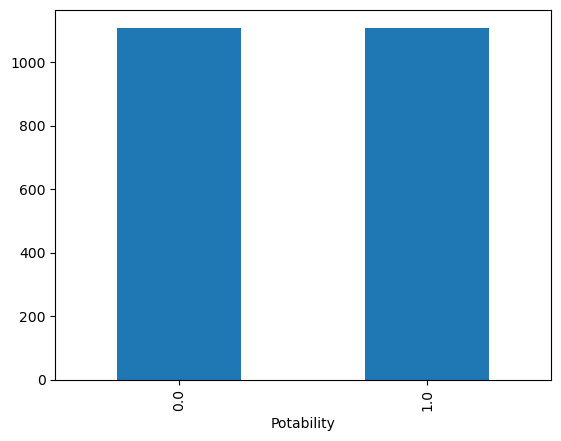

In [10]:
df_scaled['Potability'].value_counts().plot(kind='bar')

# ** First KNN**
---

In [11]:
possible_predictors = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
                       'Organic_carbon', 'Trihalomethanes', 'Turbidity']
target = 'Potability'

# Seleccionar las características deseadas y convertir las variables categóricas en variables dummy
Xs = pd.get_dummies(X_resampled[possible_predictors], drop_first=True)

### *Estandarización de datos*
---

In [12]:
# standardize data
scaler = preprocessing.StandardScaler()
scaler.fit(Xs)
Xs = pd.DataFrame(scaler.transform(Xs), columns=Xs.columns)

### *Set up experimentation*
---

In [13]:
X_train, X_test, y_train, y_test = train_test_split(Xs, y_resampled, test_size=0.3, random_state=1)

print(X_train.shape,X_test.shape,y_train.shape, y_test.shape)

(1552, 9) (666, 9) (1552,) (666,)


## *Selección de features mas importantes*
---

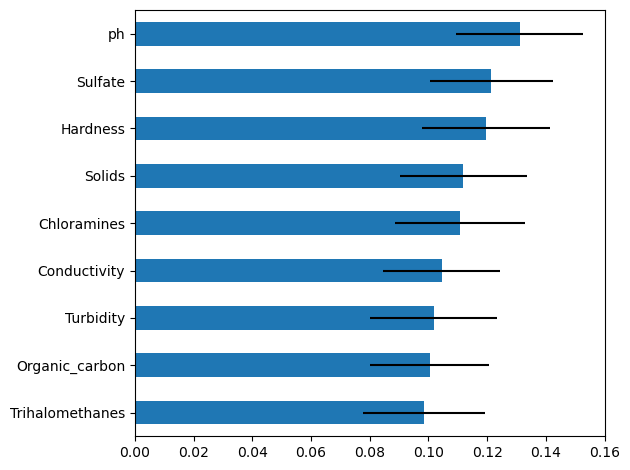

(1552, 9) (666, 9) (1552,) (666,)


In [14]:
rf = RandomForestClassifier(n_estimators=1000, random_state=2)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

df_balanced = pd.DataFrame({'feature': X_train.columns, 'importance': importances, 'std': std})
df_balanced = df_balanced.sort_values('importance')

select_features = df_balanced[df_balanced.importance >= 0.05].feature

ax = df_balanced.plot(kind='barh', xerr='std', x='feature', legend=False)
ax.set_ylabel('')
plt.tight_layout()
plt.show()

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Error

In [15]:
from sklearn.metrics import roc_auc_score

def mide_error(model_name, y_pred):
    auc = roc_auc_score(y_test, y_pred)
    print(f'{model_name} AUC: {auc:.4f}')

# MLP

In [16]:
Methods = []
Metrics = ['Accuracy','Recall','Precision','Fscore']

compare_df = pd.DataFrame(index = Methods, columns = Metrics)

In [17]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=5)
mlp.fit(X_train, y_train)
y_predict_mlp = mlp.predict(X_test)

In [18]:
mlp_report = classification_report(y_test, y_predict_mlp)

print(mlp_report)

              precision    recall  f1-score   support

         0.0       0.59      0.62      0.60       326
         1.0       0.62      0.59      0.60       340

    accuracy                           0.60       666
   macro avg       0.60      0.60      0.60       666
weighted avg       0.60      0.60      0.60       666



# Tuned DT

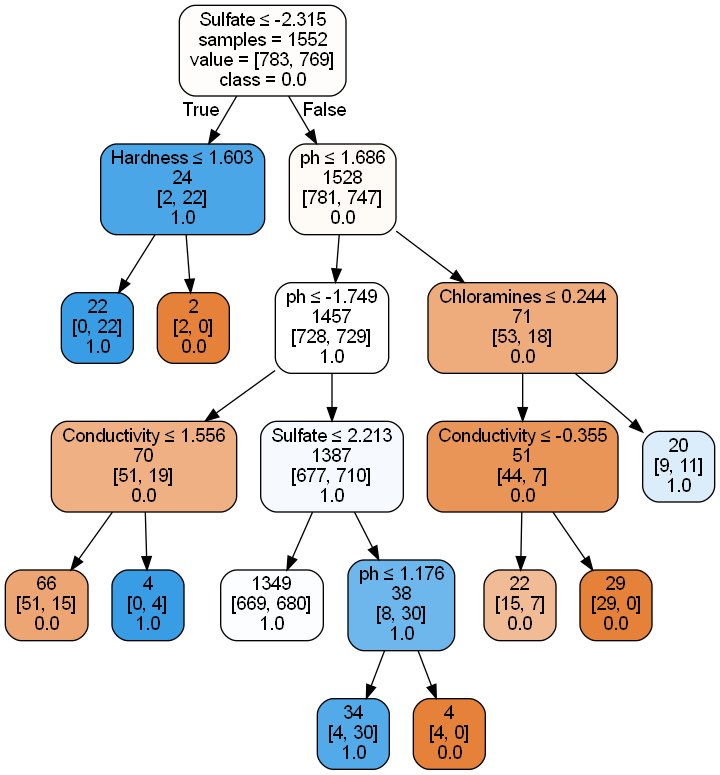

In [30]:
classTree = DecisionTreeClassifier(criterion= 'entropy', max_depth= 20,
                                   min_impurity_decrease= 0.005, min_samples_split= 20, splitter= 'best')
classTree.fit(X_train, y_train)

plotDecisionTree(classTree, feature_names=X_train.columns, class_names=classTree.classes_)

In [32]:
y_predict_dt = classTree.predict(X_test)

#---
y_predict_dt = classTree.predict(X_test)

dt_report = classification_report(y_test, y_predict_dt)
#---
print(dt_report)

              precision    recall  f1-score   support

         0.0       0.71      0.13      0.21       326
         1.0       0.53      0.95      0.68       340

    accuracy                           0.55       666
   macro avg       0.62      0.54      0.45       666
weighted avg       0.62      0.55      0.45       666



# Tune MLP


In [20]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=1, test_size=0.2, random_state=1)

param_grid = {
    'hidden_layer_sizes':[5],
    'activation': ['identity','logistic','tanh','relu'],
    'solver': ['lbfgs','sgd','adam'],
    'learning_rate':['constant','invscaling','adaptive']}

gridSearch = GridSearchCV(MLPClassifier(), param_grid, cv=cv,
                          scoring=['recall','f1'],refit='f1',verbose=2)
y_predict_Tmlp = gridSearch.fit(X_train, y_train.replace({'yes':1,'no':0}))

#------------------------------------------------------------
# Realizar predicciones en el conjunto de prueba
y_predict_Tmlp = gridSearch.predict(X_test)

# Generar un informe detallado de clasificación
Tmlp_report = classification_report(y_test, y_predict_Tmlp)

print('Score: ', gridSearch.best_score_)
print('Parameters: ', gridSearch.best_params_)

Fitting 1 folds for each of 36 candidates, totalling 36 fits
[CV] END activation=identity, hidden_layer_sizes=5, learning_rate=constant, solver=lbfgs; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=5, learning_rate=constant, solver=sgd; total time=   0.2s
[CV] END activation=identity, hidden_layer_sizes=5, learning_rate=constant, solver=adam; total time=   0.1s
[CV] END activation=identity, hidden_layer_sizes=5, learning_rate=invscaling, solver=lbfgs; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=5, learning_rate=invscaling, solver=sgd; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=5, learning_rate=invscaling, solver=adam; total time=   0.2s
[CV] END activation=identity, hidden_layer_sizes=5, learning_rate=adaptive, solver=lbfgs; total time=   0.0s
[CV] END activation=identity, hidden_layer_sizes=5, learning_rate=adaptive, solver=sgd; total time=   0.4s
[CV] END activation=identity, hidden_layer_sizes=5, learning_rate=ada

In [21]:
print(Tmlp_report)

              precision    recall  f1-score   support

         0.0       0.61      0.65      0.63       326
         1.0       0.64      0.59      0.61       340

    accuracy                           0.62       666
   macro avg       0.62      0.62      0.62       666
weighted avg       0.62      0.62      0.62       666



In [ ]:
param_grid = {
    'hidden_layer_sizes':[5,10,15,(5,5),(5,10)],
    'activation': ['relu'],
    'solver': ['adam'],
    'learning_rate':['invscaling']
}

gridSearch = GridSearchCV(MLPClassifier(), param_grid, cv=cv,
                          scoring='recall',verbose=2)
gridSearch.fit(X_train, y_train.replace({'yes':1,'no':0}))

y_pred_Tmlp2 = gridSearch.predict_proba(X_test)[:, 1]
#---
# Realizar predicciones en el conjunto de prueba
y_predict_Tmlp2 = gridSearch.predict(X_test)

# Generar un informe detallado de clasificación
Tmlp2_report = classification_report(y_test, y_predict_Tmlp2)

#---
print('Score: ', gridSearch.best_score_)
print('Parameters: ', gridSearch.best_params_)

In [ ]:
print(Tmlp2_report)

In [35]:
param_grid = {
    'hidden_layer_sizes':[5,10,15,(5,5),(5,10)],
    'activation': ['identity'],
    'solver': ['adam'],
    'alpha': [0,0.0005,0.0001,0.0005,0.001],
    'learning_rate':['invscaling'],
    'learning_rate_init': [0,0.0001,0.0005,0.001, 0.005,0.01],
    'max_iter': [200,500],
    'shuffle': [True,False] 
}

gridSearch = GridSearchCV(MLPClassifier(), param_grid, cv=cv,
                          scoring='recall',verbose=2)
y_predict_Tmlp3 = gridSearch.fit(X_train, y_train.replace({'yes':1,'no':0}))

#---
# Realizar predicciones en el conjunto de prueba
y_predict_Tmlp3 = grid_search.predict(X_test)

# Generar un informe detallado de clasificación
Tmlp3_report = classification_report(y_test, y_predict_Tmlp3)

#---

print('Score: ', gridSearch.best_score_)
print('Parameters: ', gridSearch.best_params_)

Fitting 1 folds for each of 600 candidates, totalling 600 fits
[CV] END activation=identity, alpha=0, hidden_layer_sizes=5, learning_rate=invscaling, learning_rate_init=0, max_iter=200, shuffle=True, solver=adam; total time=   0.0s
[CV] END activation=identity, alpha=0, hidden_layer_sizes=5, learning_rate=invscaling, learning_rate_init=0, max_iter=200, shuffle=False, solver=adam; total time=   0.0s
[CV] END activation=identity, alpha=0, hidden_layer_sizes=5, learning_rate=invscaling, learning_rate_init=0, max_iter=500, shuffle=True, solver=adam; total time=   0.0s
[CV] END activation=identity, alpha=0, hidden_layer_sizes=5, learning_rate=invscaling, learning_rate_init=0, max_iter=500, shuffle=False, solver=adam; total time=   0.0s
[CV] END activation=identity, alpha=0, hidden_layer_sizes=5, learning_rate=invscaling, learning_rate_init=0.0001, max_iter=200, shuffle=True, solver=adam; total time=   0.3s
[CV] END activation=identity, alpha=0, hidden_layer_sizes=5, learning_rate=invscaling

In [36]:
print(Tmlp3_report)

              precision    recall  f1-score   support

         0.0       0.52      0.51      0.51       326
         1.0       0.54      0.55      0.54       340

    accuracy                           0.53       666
   macro avg       0.53      0.53      0.53       666
weighted avg       0.53      0.53      0.53       666

